## Step 1: train_model.ipynb with Trust Score

We now:
1. Generate synthetic normal data.
2. Preprocess (one-hot + scaling).
3. Train IsolationForest.
4. Compute anomaly scores on training set, derive `score_min`, `score_max`.
5. Save scaler, model, and trust parameters for use in `client.py`.

Trust score for a new sample is:  `(score - score_min) / (score_max - score_min)`, clipped to [0,1].


In [3]:
# Imports
import os
import json
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import joblib

### Setup directories
Ensure `dataset/` and `models/` exist.

In [4]:
os.makedirs("dataset", exist_ok=True)
os.makedirs("models", exist_ok=True)
print("Directories 'dataset/' and 'models/' are ready.")

Directories 'dataset/' and 'models/' are ready.


### Generate Synthetic Normal Data
Change `n_samples` as needed.

In [5]:
COMMON_PORTS = [80,443,22,8080]
def generate_normal_data_entry():
    return {
        "src_port": random.choice(COMMON_PORTS),
        "dst_port": random.randint(1024,65535),
        "packet_size": random.randint(100,1500),
        "duration_ms": random.randint(50,500),
        "protocol": random.choice(["TCP","UDP"])
    }

# Number of samples
n_samples = 1000000  # adjust as needed
dataset = [generate_normal_data_entry() for _ in range(n_samples)]

# Save synthetic data
training_data_path = "dataset/training_data.json"
with open(training_data_path, "w") as f:
    json.dump(dataset, f, indent=2)
print(f"Generated {n_samples} synthetic normal samples and saved to {training_data_path}.")

Generated 1000000 synthetic normal samples and saved to dataset/training_data.json.


### Load and Inspect Raw Data

In [6]:
# Load synthetic data
with open("dataset/training_data.json") as f:
    raw_data = json.load(f)
df = pd.DataFrame(raw_data)
print("Raw data sample:")
display(df.head())
print("DataFrame info:")
display(df.info())
print("Descriptive statistics:")
display(df.describe(include='all'))

Raw data sample:


,src_port,dst_port,packet_size,duration_ms,protocol
0,80,30934,886,111,TCP
1,22,10168,1259,145,TCP
2,443,30369,698,51,UDP
3,80,63147,519,159,TCP
4,22,64031,1328,252,TCP


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   src_port     1000000 non-null  int64 
 1   dst_port     1000000 non-null  int64 
 2   packet_size  1000000 non-null  int64 
 3   duration_ms  1000000 non-null  int64 
 4   protocol     1000000 non-null  object
dtypes: int64(4), object(1)
memory usage: 38.1+ MB


None

Descriptive statistics:


,src_port,dst_port,packet_size,duration_ms,protocol
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000
unique,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,TCP
freq,NaN,NaN,NaN,NaN,500128
mean,2156.640500,33258.156885,800.293363,275.012435,NaN
std,3423.925201,18620.993660,404.102780,130.358322,NaN
min,22.000000,1024.000000,100.000000,50.000000,NaN
25%,80.000000,17132.000000,451.000000,162.000000,NaN
50%,443.000000,33236.000000,800.000000,275.000000,NaN
75%,8080.000000,49379.000000,1150.000000,388.000000,NaN


from matplotlib import pyplot as plt
_df_0['src_port'].plot(kind='hist', bins=20, title='src_port')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['dst_port'].plot(kind='hist', bins=20, title='dst_port')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['packet_size'].plot(kind='hist', bins=20, title='packet_size')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['duration_ms'].plot(kind='hist', bins=20, title='duration_ms')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('protocol').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='src_port', y='dst_port', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='dst_port', y='packet_size', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='packet_size', y='duration_ms', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['src_port'].plot(kind='line', figsize=(8, 4), title='src_port')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['dst_port'].plot(kind='line', figsize=(8, 4), title='dst_port')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['packet_size'].plot(kind='line', figsize=(8, 4), title='packet_size')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['duration_ms'].plot(kind='line', figsize=(8, 4), title='duration_ms')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['protocol'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='src_port', y='protocol', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['protocol'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='dst_port', y='protocol', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['protocol'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='packet_size', y='protocol', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['protocol'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='duration_ms', y='protocol', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### Preprocessing Function (One-hot)
We will later scale.


In [22]:
from sklearn.preprocessing import StandardScaler

# During training, fit a scaler on numeric columns; during inference, reuse it.
numeric_cols = ['packet_size', 'duration_ms']

def fit_preprocessor(df: pd.DataFrame):
    df_copy = df.copy()
    # 1. Protocol one-hot (keep both columns)
    proto_dummies = pd.get_dummies(df_copy['protocol'], prefix='protocol', drop_first=False)
    df_copy = pd.concat([df_copy.drop(columns=['protocol']), proto_dummies], axis=1)
    for col in ['protocol_TCP', 'protocol_UDP']:
        if col not in df_copy:
            df_copy[col] = 0

    # 2. src_port categorical
    COMMON_PORTS = [80, 443, 22, 8080]
    # indicator if in common ports
    df_copy['is_src_common'] = df_copy['src_port'].apply(lambda x: 1 if x in COMMON_PORTS else 0)
    # one-hot for each common port (optional, can help distinguish)
    for p in COMMON_PORTS:
        df_copy[f'src_{p}'] = df_copy['src_port'].apply(lambda x: 1 if x == p else 0)
    # (we keep these instead of raw src_port numeric)

    # 3. dst_port bins
    # define bins: low (<10240), mid (10240–49151), high (>=49152); plus suspicious high (>=60000)
    df_copy['dst_low'] = df_copy['dst_port'].apply(lambda x: 1 if x < 10240 else 0)
    df_copy['dst_mid'] = df_copy['dst_port'].apply(lambda x: 1 if 10240 <= x < 49152 else 0)
    df_copy['dst_high'] = df_copy['dst_port'].apply(lambda x: 1 if x >= 49152 else 0)
    df_copy['dst_suspicious'] = df_copy['dst_port'].apply(lambda x: 1 if x >= 60000 else 0)
    # (omit raw dst_port numeric)

    # 4. Numeric features: packet_size and duration_ms remain numeric
    # 5. Collect feature columns
    feature_cols = [
        # src features
        'is_src_common',
        # optionally include 'src_80','src_443','src_22','src_8080'
    ] + [f'src_{p}' for p in COMMON_PORTS] + [
        # dst bins
        'dst_low','dst_mid','dst_high','dst_suspicious',
        # numeric
        'packet_size','duration_ms',
        # protocol
        'protocol_TCP','protocol_UDP'
    ]
    # Ensure all columns exist
    for col in feature_cols:
        if col not in df_copy:
            df_copy[col] = 0

    df_features = df_copy[feature_cols].copy()

    # 6. Fit scaler on numeric columns
    scaler = StandardScaler()
    df_features[numeric_cols] = scaler.fit_transform(df_features[numeric_cols])

    return scaler, feature_cols

def preprocess_with_scaler(df: pd.DataFrame, scaler: StandardScaler, feature_cols: list) -> pd.DataFrame:
    """
    Apply preprocessing at inference time:
    - One-hot/bins identical to training
    - Scale numeric columns with fitted scaler
    Returns DataFrame with feature_cols columns.
    """
    df_copy = df.copy()
    # Protocol one-hot
    proto = df_copy.get('protocol', None)
    # If protocol column exists:
    if 'protocol' in df_copy:
        proto_vals = df_copy['protocol'].apply(lambda x: str(x).upper())
        df_copy['protocol_TCP'] = proto_vals.apply(lambda x: 1 if x == 'TCP' else 0)
        df_copy['protocol_UDP'] = proto_vals.apply(lambda x: 1 if x == 'UDP' else 0)
    else:
        df_copy['protocol_TCP'] = 0
        df_copy['protocol_UDP'] = 0

    # src_port categorical
    COMMON_PORTS = [80, 443, 22, 8080]
    df_copy['is_src_common'] = df_copy['src_port'].apply(lambda x: 1 if x in COMMON_PORTS else 0)
    for p in COMMON_PORTS:
        df_copy[f'src_{p}'] = df_copy['src_port'].apply(lambda x: 1 if x == p else 0)

    # dst_port bins
    df_copy['dst_low'] = df_copy['dst_port'].apply(lambda x: 1 if x < 10240 else 0)
    df_copy['dst_mid'] = df_copy['dst_port'].apply(lambda x: 1 if 10240 <= x < 49152 else 0)
    df_copy['dst_high'] = df_copy['dst_port'].apply(lambda x: 1 if x >= 49152 else 0)
    df_copy['dst_suspicious'] = df_copy['dst_port'].apply(lambda x: 1 if x >= 60000 else 0)

    # Ensure numeric columns exist
    for col in ['packet_size','duration_ms']:
        if col not in df_copy:
            df_copy[col] = 0

    # Ensure feature_cols exist
    for col in feature_cols:
        if col not in df_copy:
            df_copy[col] = 0

    df_features = df_copy[feature_cols].copy()

    # Scale numeric cols
    df_features[numeric_cols] = scaler.transform(df_features[numeric_cols])

    return df_features


### Preprocess & Scale Dataset
- One-hot then standard-scale.

In [23]:
# 1. Fit preprocessing on training df
scaler, feature_cols = fit_preprocessor(df)

# Save scaler and feature_cols for inference
import json
os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/scaler.joblib")
with open("models/feature_cols.json", "w") as f:
    json.dump(feature_cols, f)

# 2. Apply preprocessing to get DataFrame of features
df_encoded = preprocess_with_scaler(df, scaler, feature_cols)
X_scaled = df_encoded.values
print("After preprocessing, sample:")
display(df_encoded.head())

# 3. Convert to numpy and inspect scaling if desired
X = df_encoded.values
print("Feature matrix shape:", X.shape)
# If you want to inspect means/vars of numeric columns:
# Note: scaler.mean_ and var_ refer only to numeric_cols used in fit_preprocessor.
print("Scaler mean (numeric cols):", scaler.mean_)
print("Scaler var  (numeric cols):", scaler.var_)


After preprocessing, sample:


,is_src_common,src_80,src_443,src_22,src_8080,dst_low,dst_mid,dst_high,dst_suspicious,packet_size,duration_ms,protocol_TCP,protocol_UDP
0,1,1,0,0,0,0,1,0,0,0.212091,-1.258167,1,0
1,1,0,0,1,0,1,0,0,0,1.135124,-0.997347,1,0
2,1,0,1,0,0,0,1,0,0,-0.253137,-1.718437,0,1
3,1,1,0,0,0,0,0,1,1,-0.696094,-0.889951,1,0
4,1,0,0,1,0,0,0,1,1,1.305873,-0.176532,1,0


Feature matrix shape: (1000000, 13)
Scaler mean (numeric cols): [800.293363 275.012435]
Scaler var  (numeric cols): [163298.89321115  16993.27519637]


### Train Isolation Forest on Scaled Data

In [24]:
model = IsolationForest(
    n_estimators=200,
    max_samples=5000,
    contamination=0.01,
    random_state=42
)
model.fit(X_scaled)



IsolationForest(contamination=0.01, max_samples=5000, n_estimators=200,
                random_state=42)

### Compute Trust Parameters from Training Set
Decision function returns anomaly score: higher = more normal. We record min and max from training.


Training anomaly score min: -0.047414, max: 0.150354


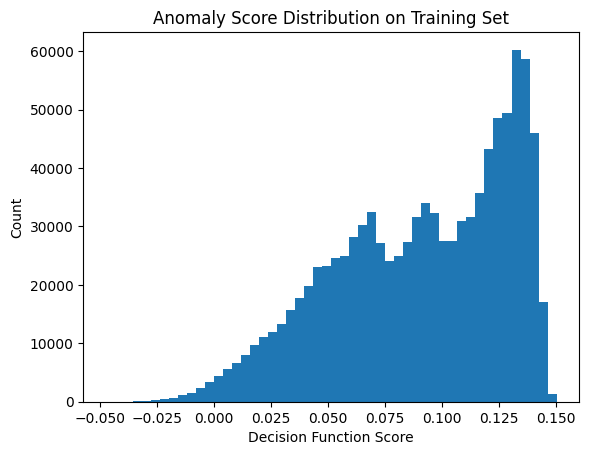

In [25]:
# Compute anomaly scores on training set
scores_train = model.decision_function(X_scaled)  # shape (n_samples,)
score_min = float(np.min(scores_train))
score_max = float(np.max(scores_train))
print(f"Training anomaly score min: {score_min:.6f}, max: {score_max:.6f}")
# Optionally inspect distribution
import matplotlib.pyplot as plt
plt.hist(scores_train, bins=50)
plt.title('Anomaly Score Distribution on Training Set')
plt.xlabel('Decision Function Score')
plt.ylabel('Count')
plt.show()

### Sanity Check on Training Set
How many flagged anomalies (~1% expected):

In [26]:
preds_train = model.predict(X_scaled)  # 1 normal, -1 anomaly
n_anomalies = np.sum(preds_train == -1)
print(f"Flagged anomalies in training: {n_anomalies} of {len(X_scaled)} (~{n_anomalies/len(X_scaled)*100:.2f}%)")

Flagged anomalies in training: 10000 of 1000000 (~1.00%)


### Save Scaler, Model, and Trust Params

In [27]:
model_path = "models/anomaly_model.joblib"
scaler_path = "models/scaler.joblib"
trust_params = {"score_min": score_min, "score_max": score_max}
trust_path = "models/trust_params.json"

# Save model and scaler with joblib
joblib.dump(model, model_path)
joblib.dump(scaler, scaler_path)
# Save trust params as JSON
with open(trust_path, "w") as f:
    json.dump(trust_params, f)
print(f"Saved model to {model_path}, scaler to {scaler_path}, trust params to {trust_path}.")

Saved model to models/anomaly_model.joblib, scaler to models/scaler.joblib, trust params to models/trust_params.json.


### Load and Test Saved Artifacts (Predict Data)
- Verify that loaded scaler/model/trust produce expected trust for sample points.

In [28]:
import json
import pandas as pd
import numpy as np
import joblib

# Ensure preprocess_with_scaler and numeric_cols are defined above exactly as in training.

# Load artifacts
loaded_model = joblib.load("models/anomaly_model.joblib")
loaded_scaler = joblib.load("models/scaler.joblib")
with open("models/feature_cols.json") as f:
    feature_cols = json.load(f)
with open("models/trust_params.json") as f:
    loaded_trust = json.load(f)
score_min = loaded_trust['score_min']
score_max = loaded_trust['score_max']
print("Loaded trust params:", loaded_trust)

def compute_trust_and_pred(sample_dict):
    df_pt = pd.DataFrame([sample_dict])
    # Preprocess exactly as training:
    df_feat = preprocess_with_scaler(df_pt, loaded_scaler, feature_cols)
    X_pt = df_feat.values  # shape (1, n_features)
    # 1. predict
    pred = loaded_model.predict(X_pt)[0]  # 1 = normal, -1 = anomaly
    # 2. score & trust
    score = loaded_model.decision_function(X_pt)[0]
    if score_max > score_min:
        trust = (score - score_min) / (score_max - score_min)
    else:
        trust = 0.0
    trust = float(np.clip(trust, 0.0, 1.0))
    return pred, trust, score

# Test on a normal sample:
test_norm = generate_normal_data_entry()
pred_norm, trust_norm, sc_norm = compute_trust_and_pred(test_norm)
print("Normal sample:", test_norm)
print(f" Prediction: {'Anomaly' if pred_norm==-1 else 'Normal'}")
print(f" Score: {sc_norm:.6f}, Trust: {trust_norm:.3f} ({trust_norm*10:.1f}/10)")

# Test on a synthetic anomaly sample:
test_anom = {"src_port": 9999, "dst_port": 65000, "packet_size": 3000,
             "duration_ms": 2000, "protocol": "TCP"}
pred_anom, trust_anom, sc_anom = compute_trust_and_pred(test_anom)
print("\nAnomaly sample:", test_anom)
print(f" Prediction: {'Anomaly' if pred_anom==-1 else 'Normal'}")
print(f" Score: {sc_anom:.6f}, Trust: {trust_anom:.3f} ({trust_anom*10:.1f}/10)")


Loaded trust params: {'score_min': -0.04741409081253234, 'score_max': 0.1503543251378494}
Normal sample: {'src_port': 8080, 'dst_port': 53215, 'packet_size': 192, 'duration_ms': 473, 'protocol': 'TCP'}
 Prediction: Normal
 Score: 0.031807, Trust: 0.401 (4.0/10)

Anomaly sample: {'src_port': 9999, 'dst_port': 65000, 'packet_size': 3000, 'duration_ms': 2000, 'protocol': 'TCP'}
 Prediction: Anomaly
 Score: -0.025750, Trust: 0.110 (1.1/10)


---
Now we have:
- `models/anomaly_model.joblib` (IsolationForest)
- `models/scaler.joblib` (StandardScaler)
- `models/trust_params.json` with `score_min` and `score_max`.

In `client.py`, load these three artifacts, then for each incoming sample:
1. One-hot encode.
2. Scale with `scaler.transform`.
3. `score = model.decision_function(X_scaled)`; `pred = model.predict(X_scaled)`.
4. `trust = (score - score_min)/(score_max-score_min)`, clipped [0,1].
5. Use `pred` and `trust` as needed (e.g., include trust in alerts/logs).
